In [1]:
import numpy as np

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from scipy.stats import norm
from scipy.stats.sampling import TransformedDensityRejection
from scipy.optimize import curve_fit
from scipy import integrate

import matplotlib.pyplot as plt

In [34]:
def GenerateData(T):
    """ generates 1D Gaussian data and labels with equal probability for both"""
    zs=np.zeros(T)
    
    #choose label first
    Y=np.random.default_rng().integers(2, size=T)

    #choose z conditional on label
    A_idx=np.where(Y==1)[0]
    B_idx=np.where(Y==0)[0]

    zsA =  norm.rvs(loc=0,scale=1,size=A_idx.shape[0]) #first Gaussian with mean 0 and variance 1
    zsB = norm.rvs(loc=5,scale=1,size=B_idx.shape[0]) # second Gaussian with mean 5 and variance 1

    zs[A_idx] = zsA
    zs[B_idx] = zsB
    
    return zs.reshape(-1,1), Y

def FitLR(X_train, Y_train):
    LR = LogisticRegression()
    LR.fit(X_train, Y_train)
    return LR

def BCELoss(model, x, y):
    reg=1e-20
    logprob = np.log(model.predict_proba(x)+reg)
    loss = -(logprob[:,1] * y + logprob[:,0] * (1 - y)).mean()
    return loss

def TrainLR(X_train, Y_train, X_test, Y_test, Ts, Navg = 10, Tmax = 10000):
    lossarr = []

    for T in Ts:
        print(T)
        if T > Tmax: #no averaging
            idx = np.random.choice(np.arange(len(X_train)), T, replace=False)
            X_sel = X_train[idx]
            Y_sel = Y_train[idx]
            cls = FitLR(X_sel, Y_sel)
            losses = BCELoss(cls,X_test,Y_test)
        else:
            losses=0
            for i in range(Navg):
                idx = np.random.choice(np.arange(len(X_train)), T, replace=False)
                X_sel = X_train[idx]
                Y_sel = Y_train[idx]
                cls = FitLR(X_sel, Y_sel)
                losses += BCELoss(cls,X_test,Y_test)/Navg
        lossarr.append(losses)
    
    return np.array(lossarr)

(array([ 20.,  98., 207., 122.,  36.,  33., 124., 217., 107.,  36.]),
 array([-2.81986741, -1.7790739 , -0.73828039,  0.30251312,  1.34330662,
         2.38410013,  3.42489364,  4.46568715,  5.50648066,  6.54727417,
         7.58806768]),
 <BarContainer object of 10 artists>)

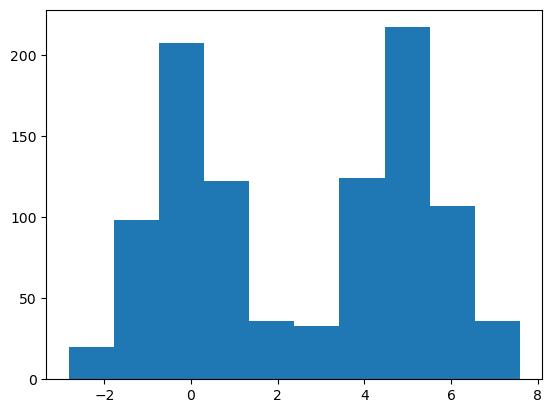

In [27]:
testdat, labels = GenerateData(1000)
plt.hist(testdat)

In [49]:
Ts = [20, 30, 40, 50, 60, 80, 100, 200, 300, 400, 500, 600, 800, 
      1000, 2000, 3000, 5000, 6000, 8000, 10000, 20000, 30000, 50000, 100000]

X_test, Y_test = GenerateData(50000)
X_train, Y_train = GenerateData(100000)

losses_LR = TrainLR(X_train, Y_train, X_test, Y_test, Ts, Navg = 1000)

20
30
40
50
60
80
100
200
300
400
500
600
800
1000
2000
3000
5000
6000
8000
10000
20000
30000
50000
100000


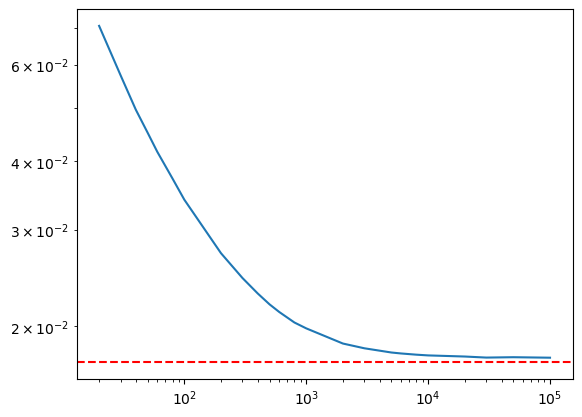

In [50]:
plt.plot(Ts,losses_LR)
plt.axhline(0.0172046,color='red',linestyle='dashed')
plt.xscale('log')
plt.yscale('log')

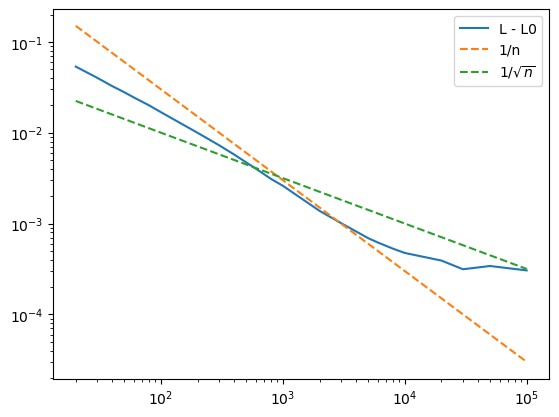

In [57]:
#approach to loss floor
plt.plot(Ts,losses_LR-0.0172046,label='L - L0')
plt.plot(Ts,3/np.array(Ts),linestyle='dashed',label='1/n')
plt.plot(Ts,.1/np.array(Ts)**(1/2),linestyle='dashed',label=r'$1/\sqrt{n}$')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right')